In [2]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 7.6 MB/s 


In [4]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 7.4 MB/s 


In [5]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors

import corner
import time as measure_time
import os

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

In [6]:
meta = pd.read_csv("meta.txt", sep='\s+', index_col = False, names = ['SNID','PEAKMJD','MWEBV','REDSHIFT_HELIO','REDSHIFT_CMB','REDSHIFT_CMB_ERR'], skiprows = 2)

In [7]:
tmax_dict = {}
mwebv_dict = {}
z_helio_dict = {}
z_cmb_dict = {}
for index, row in meta.iterrows():
  name = row['SNID']
  tmax = row['PEAKMJD']
  mwebv = row['MWEBV']
  z_helio = row['REDSHIFT_HELIO']
  z_cmb = row['REDSHIFT_CMB']
  tmax_dict[name] = tmax
  mwebv_dict[name] = mwebv
  z_helio_dict[name] = z_helio
  z_cmb_dict[name] = z_cmb

In [8]:
cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)

In [10]:
laplace_vi_scale_tril_dict = np.load("foundation_laplace_scale_tril_redo2.npy", allow_pickle = True).item()
laplace_vi_loc_dict = np.load("foundation_laplace_loc_redo2.npy", allow_pickle = True).item()
# laplace_samples_dict = np.load("foundation_laplace_samples.npy", allow_pickle = True).item()

In [11]:
len(laplace_vi_loc_dict)

156

In [12]:
laplace_vi_mus = []
laplace_vi_vars = []
laplace_vi_z_cmbs = []


for sn in list(laplace_vi_loc_dict.keys()):
    laplace_vi_mus.append(laplace_vi_loc_dict[sn][-2])
    laplace_vi_scale_tril = laplace_vi_scale_tril_dict[sn]
    laplace_vi_vars.append(np.matmul(laplace_vi_scale_tril, laplace_vi_scale_tril.T)[-2][-2])
    laplace_vi_z_cmbs.append(z_cmb_dict[sn])

In [13]:
predictions = laplace_vi_mus
targets = np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs])

rmse = np.sqrt(np.mean((predictions-targets)**2))
print(rmse)

0.13618265833700324


In [14]:
linspace_z = np.linspace(0.01, 0.085)

cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
cosmo_distmod_values = np.array([cosmo.distmod(z).value for z in linspace_z])

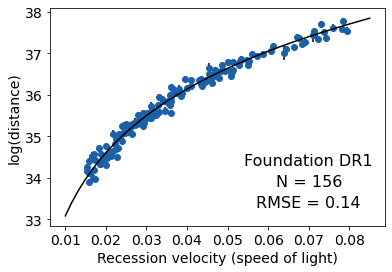

In [15]:
f = plt.figure()
plt.plot(laplace_vi_z_cmbs, laplace_vi_mus, 'o', color = (0.104,0.382,0.664))
plt.plot(linspace_z, cosmo_distmod_values, color = 'k')
plt.errorbar(laplace_vi_z_cmbs, laplace_vi_mus, np.sqrt(laplace_vi_vars), linestyle = 'None', color = 'k')
plt.xlabel("Recession velocity (speed of light)", fontsize =14)
plt.ylabel("log(distance)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(0.07, 34.3, "Foundation DR1", fontsize = 16, horizontalalignment = 'center')
plt.text(0.07, 33.8, "N = " + str(len(laplace_vi_z_cmbs)), fontsize = 16, horizontalalignment = 'center')
plt.text(0.07, 33.3, "RMSE = " + str(round(rmse,2)), fontsize = 16, horizontalalignment = 'center')
f.savefig("HubbleDiagram.pdf", bbox_inches = 'tight')
# plt.title("Foundation dataset distances- VI initialized with Laplace", fontsize = 12)

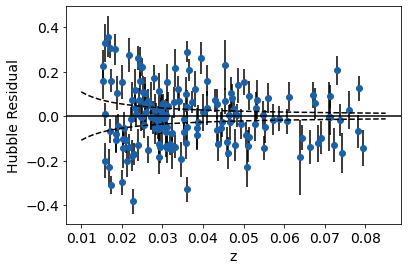

In [16]:
g = plt.figure()
plt.plot(laplace_vi_z_cmbs, laplace_vi_mus - np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs]), 'o',color = (0.104,0.382,0.664))

plt.errorbar(laplace_vi_z_cmbs, laplace_vi_mus - np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs]), np.sqrt(laplace_vi_vars), linestyle = 'None', color = 'k')


sigma_pec = 150
c = 300000

sigma_envelope = np.array([(5 / (z * np.log(10))) * (sigma_pec / c) for z in linspace_z])

plt.plot(linspace_z, sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')
plt.plot(linspace_z, -sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')

plt.axhline(0., color = 'k')

plt.xlabel("z", fontsize = 14)
plt.ylabel("Hubble Residual", fontsize = 14)
# plt.ylim(-1, 1)
# plt.title("Foundation dataset residuals- VI initialized with Laplace", fontsize = 12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()
g.savefig("HubbleResiduals.pdf", bbox_inches = 'tight')

In [17]:
sn

'iPTF16auf'

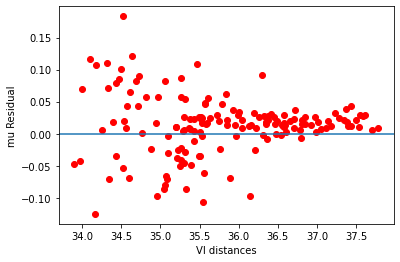

In [20]:
mu_residuals = []
av_residuals = []
theta_residuals = []

mcmc_mus = []
mcmc_av = []
mcmc_theta = []

sample_mus = []
sample_av = []
sample_theta = []

posterior_mus = []
posterior_av = []
posterior_theta = []

for sn in list(laplace_vi_loc_dict.keys()):
  estimated_dist = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['mu'])
  estimated_av = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['AV'])
  estimated_theta = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['theta'])

  mcmc_mus.append(estimated_dist)
  mcmc_av.append(estimated_av)
  mcmc_theta.append(estimated_theta)


  # supernova_samples = laplace_samples_dict[sn]
  # sample_mus.append(np.median(supernova_samples['mu_s'].numpy()))
  # sample_av.append(np.median(supernova_samples['Av'].numpy()))
  # sample_theta.append(np.median(supernova_samples['theta'].numpy()))

  posterior_mus.append(laplace_vi_loc_dict[sn][-2])
  posterior_av.append(np.exp(laplace_vi_loc_dict[sn][-1]))
  posterior_theta.append(laplace_vi_loc_dict[sn][-3])
  # print(estimated_dist)
  # print(vi_loc_dict[sn][-2])
  # plt.plot(laplace_vi_loc_dict[sn][-2], estimated_dist, 'bo')
  plt.plot(laplace_vi_loc_dict[sn][-2], estimated_dist - laplace_vi_loc_dict[sn][-2], 'ro')
  mu_residuals.append(estimated_dist - laplace_vi_loc_dict[sn][-2])
  av_residuals.append(estimated_av - np.exp(laplace_vi_loc_dict[sn][-1]))
  # print(laplace_vi_loc_dict[sn][-1])
  theta_residuals.append(estimated_theta - laplace_vi_loc_dict[sn][-3])

# plt.plot(np.linspace(33,38), np.linspace(33, 38), color = 'tab:orange')
plt.xlabel("VI distances")
# plt.ylabel("MCMC distances")
plt.ylabel("mu Residual")
plt.axhline(0)

# sample_residuals = np.array(mcmc_mus) - np.array(sample_mus)
# plt.plot(sample_mus, sample_residuals, 'o')

plt.show()

ValueError: ignored

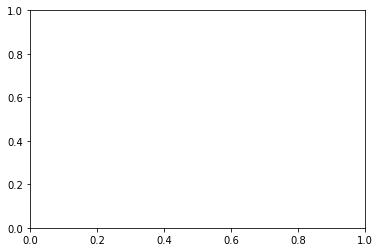

In [21]:
plt.plot(sample_mus, posterior_mus, 'o')
plt.plot(np.linspace(34, 38),np.linspace(34, 38))
plt.xlabel("Mu from samples")
plt.ylabel("Mu from posterior distribution")

In [ ]:
plt.plot(sample_av, posterior_av, 'o')
plt.plot(np.linspace(0, 1),np.linspace(0, 1))
plt.xlabel("Av from samples")
plt.ylabel("Av from posterior distribution")

In [ ]:
plt.plot(sample_theta, posterior_theta, 'o')
plt.plot(np.linspace(-2, 3),np.linspace(-2, 3))
plt.xlabel("Theta from samples")
plt.ylabel("Theta from posterior distribution")

Text(0.5, 0, 'MCMC av')

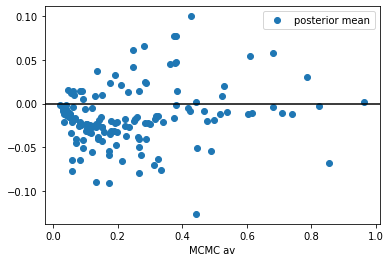

In [22]:
plt.plot(mcmc_av, av_residuals, 'o', label = 'posterior mean')
# sample_av_residuals = np.array(mcmc_av) - np.array(sample_av)
# plt.plot(mcmc_av, sample_av_residuals, 'o', label = 'sample median')
plt.axhline(0, color = 'k')
plt.legend()
plt.xlabel("MCMC av")

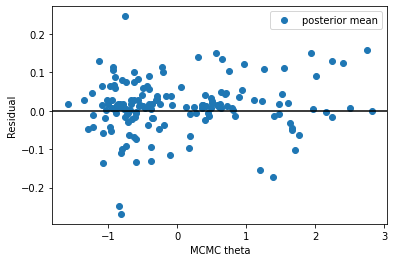

In [23]:
plt.plot(mcmc_theta, theta_residuals, 'o', label = 'posterior mean')
# sample_theta_residuals = np.array(mcmc_theta) - np.array(sample_theta)
# plt.plot(mcmc_theta, sample_theta_residuals, 'o', label = 'sample median')
plt.axhline(0, color = 'k')
plt.xlabel("MCMC theta")
plt.ylabel("Residual")
plt.legend()

## Do MCMC to see if it's biased too

In [24]:
np.argsort(np.fabs(av_residuals))[-5:]

array([ 89, 117,  33, 155, 133])

In [25]:
biased_sn = np.array(list(laplace_vi_loc_dict.keys()))[np.argsort(np.fabs(av_residuals))[-5:]]

In [26]:
W0 = np.loadtxt("W0.txt")
W1 = np.loadtxt("W1.txt")
W0_tensor = torch.as_tensor(W0)
W1_tensor = torch.as_tensor(W1)
time_knots = np.loadtxt("tau_knots.txt")
wavelength_knots = np.loadtxt("l_knots.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon.txt")
L_sigma_epsilon_tensor = torch.as_tensor(L_sigma_epsilon, dtype = torch.float)
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA.txt")
cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)

In [27]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

In [28]:
ZPT = torch.as_tensor(27.5)
M0 = torch.as_tensor(-19.5)
gamma = torch.as_tensor(np.log(10) / 2.5)
gamma_numpy = np.log(10) / 2.5

hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

bands = ['g', 'r', 'i', 'z']
wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

In [29]:
def get_fluxes_from_file(filename, tmax, z_helio):
  df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
  df = df.dropna()

  # Remove time points outside of [-10., 40.]
  df['adj_time'] = (df.MJD - tmax) / (1 + z_helio)
  mask = (df['adj_time'] < 40.) & (df['adj_time'] > -10.0)
  df = df[mask]

  # Separate based on bands
  g_time = df.adj_time[df.FLT=='g'].values
  r_time = df.adj_time[df.FLT=='r'].values
  i_time = df.adj_time[df.FLT=='i'].values
  z_time = df.adj_time[df.FLT=='z'].values

  g_flux = df.FLUXCAL[df.FLT=='g'].values
  r_flux = df.FLUXCAL[df.FLT=='r'].values
  i_flux = df.FLUXCAL[df.FLT=='i'].values
  z_flux = df.FLUXCAL[df.FLT=='z'].values

  g_fluxerr = df.FLUXCALERR[df.FLT=='g'].values
  r_fluxerr = df.FLUXCALERR[df.FLT=='r'].values
  i_fluxerr = df.FLUXCALERR[df.FLT=='i'].values
  z_fluxerr = df.FLUXCALERR[df.FLT=='z'].values

  times_dict = {'g':g_time, 'r':r_time, 'i':i_time, 'z':z_time}

  observed_fluxes = [torch.as_tensor(g_flux), torch.as_tensor(r_flux), torch.as_tensor(i_flux), torch.as_tensor(z_flux)]

  flux_errors = [torch.as_tensor(g_fluxerr), torch.as_tensor(r_fluxerr), torch.as_tensor(i_fluxerr), torch.as_tensor(z_fluxerr)]

  return observed_fluxes, flux_errors, times_dict

In [30]:
def get_lambda_int_for_band(band_wavelengths, z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 150)

In [31]:
def calculate_band_dependent_stuff(times_dict, z_helio, Av_obs):
  band_Jl = {}
  band_h = {}
  band_Jt = {}
  band_xis_matrix = {}
  band_S0 = {}  

  for band in bands:
    # Calculate Jt
    times_to_interpolate = times_dict[band]
    Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
    band_Jt[band] = torch.as_tensor(Jt.T)

    # Calculate wavelengths to interpolate
    band_wavelengths = wavelengths_dict[band]
    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z = z_helio)

    # Calculate Jl (J matrix for wavelengths)
    Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    band_Jl[band] = torch.as_tensor(Jl)

    # Calculate xis matrix
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
    band_xis_matrix[band] = torch.as_tensor(xis_matrix)

    # Interpolate throughput wavelengths
    band_norm_throughput = norm_throughput_dict[band]
    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z_helio)) + [band_wavelengths[-1]])

    # Calculate S0 matrix
    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time_point in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)
    band_S0[band] = torch.as_tensor(S0)

    # Calculate h
    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z_helio), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z_helio) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma_numpy * xis_obs)
    band_h[band] = torch.as_tensor(h)

  return band_Jt, band_Jl, band_xis_matrix, band_S0, band_h

In [32]:
def model_vi_with_params_faster(obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors):
  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(54), torch.eye(54)))
  epsilon_interior = torch.matmul(L_sigma_epsilon_tensor.float(), nu.float())

  theta = pyro.sample("theta", dist.Normal(0.,1.))

  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, 10.0))

  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))

  # epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  # epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)
  epsilon = torch.vstack((torch.zeros(6), torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1), torch.zeros(6)))

  W = W0_tensor + theta*W1_tensor + epsilon

  generated_fluxes = np.empty(4, object)

  for band_index, band in enumerate(bands):
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    # for var in [Jl, S0, xis_matrix, h, Jt]:
    #   print(var.get_device())

    JlWJt = torch.matmul(band_Jl[band], torch.matmul(W, band_Jt[band]))

    Stilde = band_S0[band] * torch.exp(-gamma * (JlWJt + Av * band_xis_matrix[band]))

    f = 10**(0.4 * (ZPT - mu_s - M0 - dMs)) * torch.matmul(band_h[band], Stilde)
    generated_fluxes[band_index] = f
    # generated_fluxes.append(f)

  for i in pyro.plate("bands", band_index + 1):
    # print(i, band_index)
    with pyro.plate("observations" + str(bands[i])):
        # print(obs[i].get_device())
        pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[i]), obs = obs[i])
        # print(obs[0][i][j])
      # print(generated_fluxes[i])


In [41]:
def train_with_params_faster(model, guide, obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, lr=0.01, n_steps=5000, verbose= False):
  pyro.get_param_store().clear()
  # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
  adam = pyro.optim.ClippedAdam({"lr": lr, "betas": (0.95, 0.999)})
  svi = SVI(model, guide, adam, loss=Trace_ELBO())
  # print('hi')
  for step in range(n_steps):
      loss = svi.step(obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors)
      if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
          ## if it hasn't decreased in 3 steps, end fitting
          # if step > 2000:
          #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
          #   break

In [42]:
biased_sn

array(['ATLAS17bas', 'PS16cvc', 'ASASSN-16ad', 'iPTF16auf', 'PSNJ1602512'],
      dtype='<U11')

In [70]:
# mcmc_samples = {}

laplace_approximations = {}

for sn in [biased_sn[2]]:
  print(sn)

  tmax = tmax_dict[sn]
  z_helio = z_helio_dict[sn]
  EBV_MW = mwebv_dict[sn]
  z_cmb = z_cmb_dict[sn]

  Av_obs = EBV_MW * 3.1
  observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

  # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
  band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio, Av_obs)
  mu_mean = torch.as_tensor(cosmo.distmod(z_cmb).value)

  start_time = measure_time.time()

  nuts_kernel = pyro.infer.NUTS(model_vi_with_params_faster, adapt_step_size=True)

  mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=250, warmup_steps=500, num_chains = 1, disable_progbar = False)

  mcmc.run(observed_fluxes, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors)
  # Fit Laplace Approximation

  # try:
  # autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
  # train_with_params_faster(model_vi_with_params_faster, autoguide_laplace, observed_fluxes, mu_mean, 
  #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000, verbose = True)
  

  # # # Fit VI based on Laplace Approximation
  # new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, mu_mean, 
  #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
  # laplace_approximations[sn] = new_laplace_approx_guide

  # train_with_params_faster(model_vi_with_params_faster, new_laplace_approx_guide, observed_fluxes, mu_mean, 
  #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=5000, verbose = True)
  
  end_time = measure_time.time()
  print("Time:", end_time - start_time, "seconds")

  # mcmc_posterior_samples = mcmc.get_samples(num_samples = 1000)
  # mcmc_samples[sn] = mcmc_posterior_samples


ASASSN-16ad


Sample: 100%|██████████| 750/750 [17:40,  1.41s/it, step size=3.83e-02, acc. prob=0.941]

Time: 1060.0095677375793 seconds


In [49]:
mcmc_samples = np.load("biased_sn_mcmc_samples(1).npy", allow_pickle = True).item()


In [52]:
# mcmc_samples

In [53]:
biased_sn

array(['ATLAS17bas', 'PS16cvc', 'ASASSN-16ad', 'iPTF16auf', 'PSNJ1602512'],
      dtype='<U11')

In [57]:
def get_laplace_samples(sn, num_samples = 1000):
  distr = laplace_approximations[sn].get_posterior()
  
  sn_vi_samples = distr.sample((num_samples,)).numpy()
  # print(np.shape(sn_vi_samples[:,-1]))
  theta_samples = sn_vi_samples[:,-3]
  av_samples = np.exp(sn_vi_samples[:,-1])
  mu_samples = sn_vi_samples[:,-2]
  return np.vstack((mu_samples, theta_samples, av_samples)).T

In [59]:
def get_vi_samples(sn, num_samples = 1000):
  # print(laplace_vi_loc_dict[sn])
  # print(laplace_vi_scale_tril_dict[sn])
  dist = torch.distributions.MultivariateNormal(torch.as_tensor(laplace_vi_loc_dict[sn]), scale_tril = torch.as_tensor(laplace_vi_scale_tril_dict[sn]))
  sn_vi_samples = dist.sample((num_samples,)).numpy()
  # print(np.shape(sn_vi_samples[:,-1]))
  theta_samples = sn_vi_samples[:,-3]
  av_samples = np.exp(sn_vi_samples[:,-1])
  mu_samples = sn_vi_samples[:,-2]
  return np.vstack((mu_samples, theta_samples, av_samples)).T

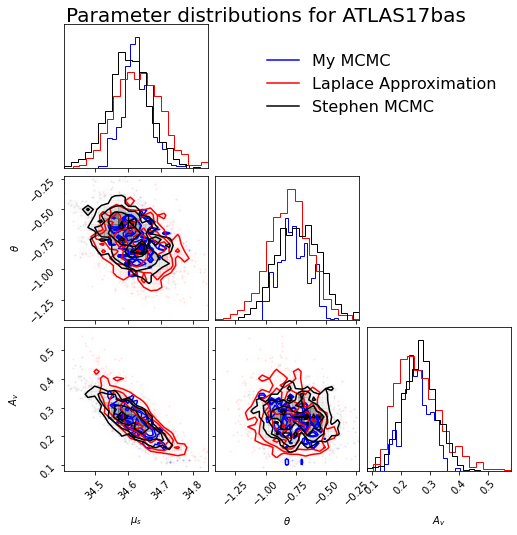

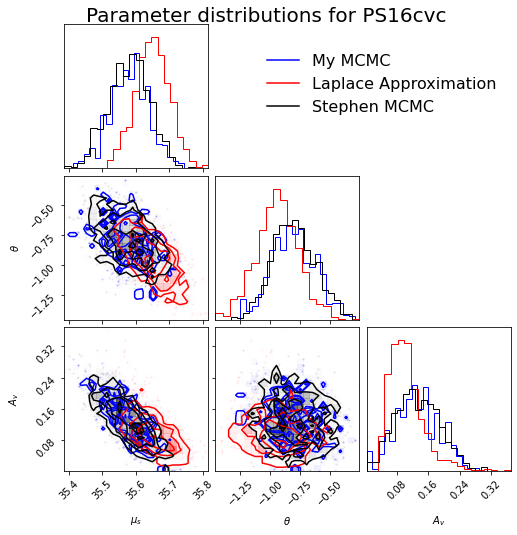

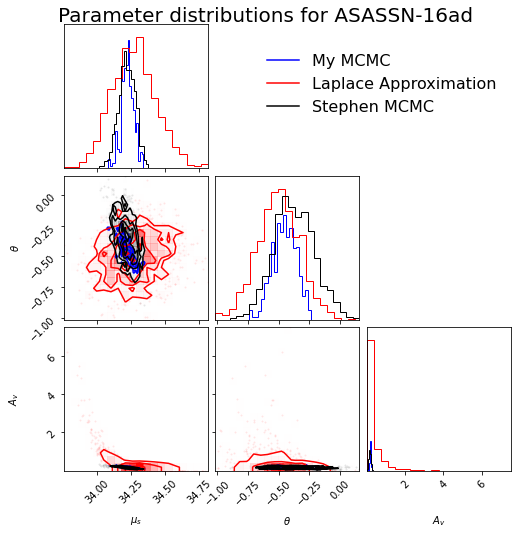

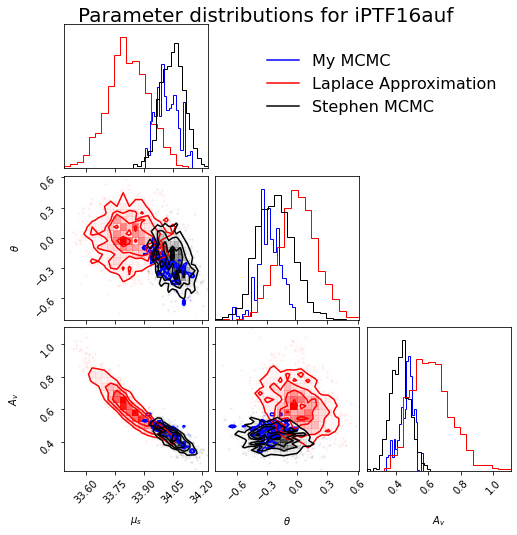

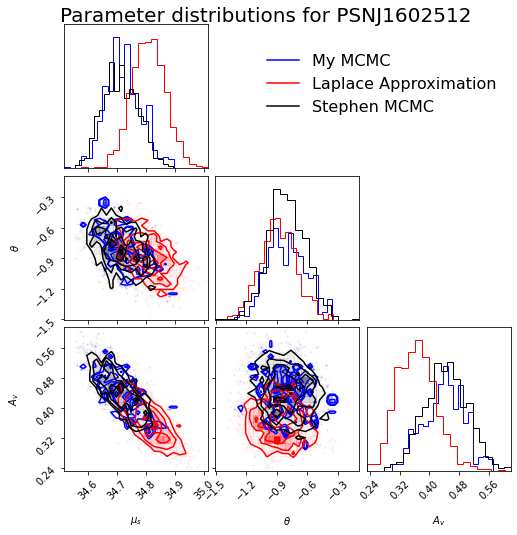

In [63]:
for sn in biased_sn:
  figure = corner.corner(np.vstack((mcmc_samples[sn]['mu_s'].numpy(),mcmc_samples[sn]['theta'].numpy(),mcmc_samples[sn]['Av'].numpy())).T, 
                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color ='b')
  # corner.corner(np.vstack((laplace_samples_dict[sn]['mu_s'].numpy(),laplace_samples_dict[sn]['theta'].numpy(),laplace_samples_dict[sn]['Av'].numpy())).T, 
  #                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
  
  # corner.corner(get_vi_samples(sn)[::4], fig = figure, color = 'r')
  corner.corner(get_laplace_samples(sn), fig = figure, color = 'r')
  observations = np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()

  corner.corner(np.vstack((observations['mu']+ observations['delM'],observations['theta'],observations['AV'])).T, 
                          labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'k')
  # print(observations.keys())
  # for i in range(4):
  #   corner.corner(np.vstack((observations['mu'][250*i:250*(i + 1)] + observations['delM'][250*i:250*(i + 1)],observations['theta'][250*i:250*(i + 1)],observations['AV'][250*i:250*(i + 1)])).T, 
  #                         labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'k')
    
  colors = ['b','r', 'k']

  labels = ['My MCMC', 'Laplace Approximation', 'Stephen MCMC']

  plt.legend(
      handles=[
          mlines.Line2D([], [], color=colors[i], label=labels[i])
          for i in range(len(labels))
      ],
      fontsize=16, frameon=False,
      bbox_to_anchor=(1, 3), loc="upper right"
  )
  figure.suptitle("Parameter distributions for " + sn, fontsize = 20)
  figure.savefig(sn+"fit.pdf", bbox_inches = 'tight')


In [ ]:
mcmc_samples['ATLAS16dqf']['Av']

In [77]:
print("Supernova","|", "Redshift")
print("--------------------")
for sn in biased_sn:
  print(sn, "|", z_helio_dict[sn])

Supernova | Redshift
--------------------
ATLAS17bas | 0.02222
PS16cvc | 0.02954
ASASSN-16ad | 0.016131
iPTF16auf | 0.015018
PSNJ1602512 | 0.020254


Text(0, 0.5, '$A_v$')

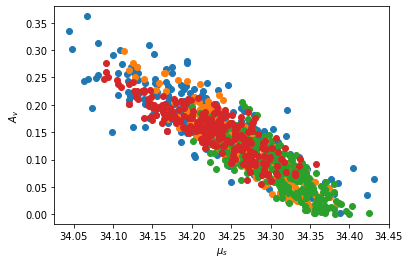

In [105]:
for i in range(4):
  plt.plot(mcmc.get_samples()['mu_s'].numpy()[250*i:250*(i + 1)], mcmc.get_samples()['Av'].numpy()[250*i:250*(i + 1)], 'o')

plt.xlabel(r"$\mu_s$")
plt.ylabel(r"$A_v$")

In [69]:
len(mcmc.get_samples()['mu_s'].numpy())

500

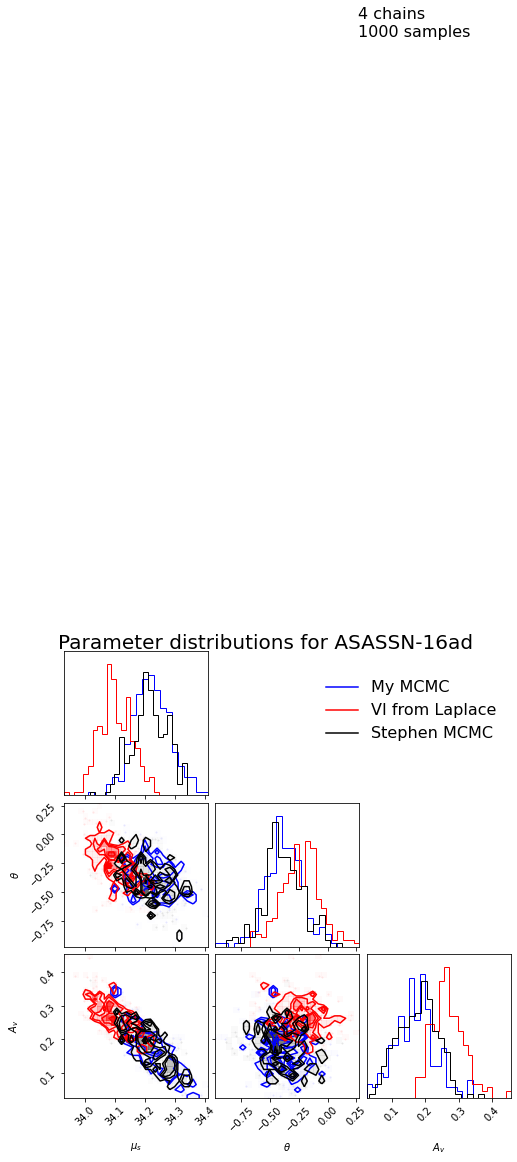

In [72]:
for sn in [biased_sn[2]]:
  figure = corner.corner(np.vstack((mcmc.get_samples()['mu_s'].numpy(),mcmc.get_samples()['theta'].numpy(),mcmc.get_samples()['Av'].numpy())).T, 
                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color ='b')
  # corner.corner(np.vstack((laplace_samples_dict[sn]['mu_s'].numpy(),laplace_samples_dict[sn]['theta'].numpy(),laplace_samples_dict[sn]['Av'].numpy())).T, 
  #                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')  
  
  corner.corner(get_vi_samples(sn)[::4], fig = figure, color = 'r')
  observations = np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()
  corner.corner(np.vstack((observations['mu'][::4] + observations['delM'][::4],observations['theta'][::4],observations['AV'][::4])).T, 
                          labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'k')
  # print(observations.keys())
  # for i in range(4):
  #   corner.corner(np.vstack((observations['mu'][250*i:250*(i + 1)] + observations['delM'][250*i:250*(i + 1)],observations['theta'][250*i:250*(i + 1)],observations['AV'][250*i:250*(i + 1)])).T, 
  #                         labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'k')
    
  colors = ['b','r', 'k']

  labels = ['My MCMC', 'VI from Laplace', 'Stephen MCMC']

  plt.legend(
      handles=[
          mlines.Line2D([], [], color=colors[i], label=labels[i])
          for i in range(len(labels))
      ],
      fontsize=16, frameon=False,
      bbox_to_anchor=(1, 3), loc="upper right"
  )

  plt.text(0,300, "4 chains \n1000 samples", fontsize = 16)
  figure.suptitle("Parameter distributions for " + sn, fontsize = 20)
  figure.savefig(sn+"fit.pdf", bbox_inches = 'tight')


In [73]:
mcmc.diagnostics()

{'Av': OrderedDict([('n_eff', tensor(108.0442, dtype=torch.float64)),
              ('r_hat', tensor(0.9961, dtype=torch.float64))]),
 'acceptance rate': {'chain 0': 1.0},
 'divergences': {'chain 0': []},
 'mu_s': OrderedDict([('n_eff', tensor(106.4085, dtype=torch.float64)),
              ('r_hat', tensor(0.9960, dtype=torch.float64))]),
 'nu': OrderedDict([('n_eff',
               tensor([ 157.3663,   70.2675,  178.0509,  198.7988,   58.4622,  307.6763,
                       1264.2277,  764.1675,  606.2223,  192.3851,  226.7860,  220.2227,
                        233.9206,  143.8304,  118.8404,  384.2260,  529.9424,  277.7825,
                        248.1792,  210.8503,  320.4413,  238.6633,  135.8706,  240.6804,
                        554.9429,  529.8944,  433.8152,  478.7097,  147.3463,  356.5404,
                        190.4725,  276.2744,  106.6654,  342.5601,  394.7147,  953.3747,
                        410.4936,  386.6088,  418.9691,  292.5667,  398.1282,  141.1922,
      

In [103]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      0.13      0.06      0.13      0.02      0.23      9.81      1.43
      mu_s     34.26      0.07     34.26     34.15     34.36      8.52      1.35
     nu[0]      0.50      0.73      0.45     -0.66      1.68     23.53      1.25
     nu[1]      0.66      0.49      0.70     -0.18      1.48     85.19      1.03
     nu[2]     -0.77      0.86     -0.79     -2.04      0.70     25.05      1.17
     nu[3]     -0.55      0.44     -0.54     -1.27      0.16     21.35      1.16
     nu[4]     -0.07      0.31     -0.07     -0.58      0.40     82.05      1.06
     nu[5]      0.80      0.69      0.78     -0.28      1.94    138.56      1.04
     nu[6]      0.78      0.89      0.80     -0.61      2.35      8.63      1.22
     nu[7]      0.33      0.99      0.42     -1.31      1.98     20.60      1.20
     nu[8]     -0.41      0.77     -0.27     -1.87      0.58     26.48      1.15
     nu[9]      0.73      0